Install required libraries:

In [ ]:
pip install pandas matplotlib opencv-python gspread oauth2client

libraries used in project

1. pandas : Reads the sensor data from test.csv.

2. matplotlib : Plots temperature/humidity trends over time.

3. opencv-python (OpenCV) : Detects pollution (haze/smoke) in images using edge detection.

4. gspread + oauth2client :

*   gspread: Interacts with Google Sheets (read/write data).

    Store sensor data in the cloud
*   oauth2client: Handles secure login to Google’s cloud.

    Authenticate with Google Sheets


**Analyzing Sensor Data**

In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#loading sensoe data
df = pd.read_csv('/content/test.csv')
df['date_time'] = pd.to_datetime(df['date_time']) # converts the "date_time" column from text/string format into a proper datetime


In [ ]:
print(df)

               date_time  deg_C  relative_humidity  absolute_humidity  \
0    2011-01-01 00:00:00    8.0               41.3             0.4375   
1    2011-01-01 01:00:00    5.1               51.7             0.4564   
2    2011-01-01 02:00:00    5.8               51.5             0.4689   
3    2011-01-01 03:00:00    5.0               52.3             0.4693   
4    2011-01-01 04:00:00    4.5               57.5             0.4650   
...                  ...    ...                ...                ...   
2242 2011-04-04 10:00:00   23.2               28.7             0.7568   
2243 2011-04-04 11:00:00   24.5               22.5             0.7119   
2244 2011-04-04 12:00:00   26.6               19.0             0.6406   
2245 2011-04-04 13:00:00   29.1               12.7             0.5139   
2246 2011-04-04 14:00:00   27.9               13.5             0.5028   

      sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  
0       1108.8     745.7     797.1     880.0    1273.1  
1       1

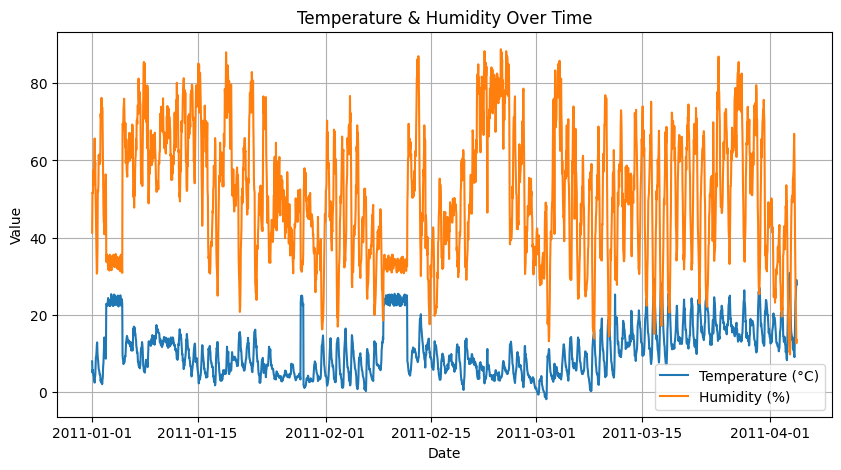

In [ ]:
# Plot Temperature & Humidity
plt.figure(figsize=(10, 5))
plt.plot(df['date_time'], df['deg_C'], label='Temperature (°C)')
plt.plot(df['date_time'], df['relative_humidity'], label='Humidity (%)')
plt.title("Temperature & Humidity Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

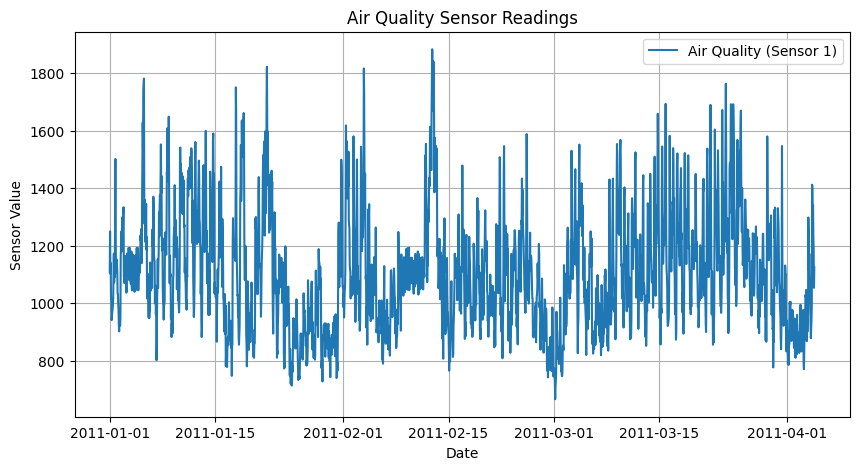

In [ ]:
# Plot Air Quality (using sensor data)
plt.figure(figsize=(10, 5))
plt.plot(df['date_time'], df['sensor_1'], label='Air Quality (Sensor 1)')
plt.title("Air Quality Sensor Readings")
plt.xlabel("Date")
plt.ylabel("Sensor Value")
plt.legend()
plt.grid(True)
plt.show()

now we will analyze images to detect pollution

Contrast: 17.24, Brightness: 220.81, Edge Mean: 0.00, Blue Intensity: 244.95, Saturation: 51.88
Detected as sky image.
Original Image:


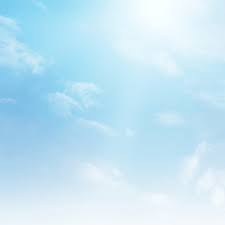

Edge Detection (Pollution Indicators):


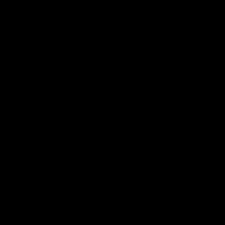


Pollution Score: 42.7/100 (higher = worse)
Air Quality: Good (Clean Air)


np.float64(42.707990123456796)

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Required for Colab image display

def detect_pollution(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {image_path}")

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Used to compute brightness/contrast.
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #Helps analyze color purity (saturation).

        # Compute contrast and brightness
        contrast = np.std(gray)
        brightness = np.mean(gray)

        # Compute edge detection
        edges = cv2.Canny(gray, 100, 200)
        edge_mean = cv2.mean(edges)[0]

        # Compute blue channel intensity (used for sky detection)
        blue_channel_mean = np.mean(img[:, :, 0])  # Extract the Blue channel

        # Compute saturation
        saturation = np.mean(hsv[:, :, 1])

        print(f"Contrast: {contrast:.2f}, Brightness: {brightness:.2f}, Edge Mean: {edge_mean:.2f}, Blue Intensity: {blue_channel_mean:.2f}, Saturation: {saturation:.2f}")

        # Determine if the image is likely a sky scene
        if contrast < 20 and blue_channel_mean > 130:  # Adjust threshold as needed
            print("Detected as sky image.")
            pollution_score = max(0, 100 - (saturation / 3))  # Reduce saturation impact # Higher = more polluted
        else:
            print("Detected as landscape image.")
            pollution_score = 100 - (edge_mean / 2)  # Pollution based on edge density

        # Adjust pollution score based on blue intensity (clear sky correction)
        if blue_channel_mean > 200 and brightness > 200:
            pollution_score = max(0, pollution_score - 40)  # Reduce pollution score for clear sky

        # Classify air quality
        if pollution_score < 25:
            air_quality = "Excellent (Very Clean Air)"
        elif pollution_score < 50:
            air_quality = "Good (Clean Air)"
        elif pollution_score < 75:
            air_quality = "Moderate (Mild Pollution)"
        else:
            air_quality = "Poor (Heavy Pollution)"

        print("Original Image:")
        cv2_imshow(img)
        print("Edge Detection (Pollution Indicators):")
        cv2_imshow(edges)
        print(f"\nPollution Score: {pollution_score:.1f}/100 (higher = worse)")
        print(f"Air Quality: {air_quality}")
        return pollution_score

    except Exception as e:
        print(f"Error: {str(e)}")
        return None

image_path = "/content/clearSKY.jpeg"
detect_pollution(image_path)


Contrast: 28.55, Brightness: 126.86, Edge Mean: 10.67, Blue Intensity: 126.85, Saturation: 19.00
Detected as landscape image.
Original Image:


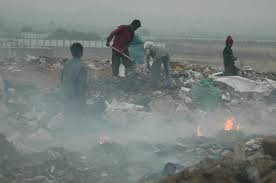

Edge Detection (Pollution Indicators):


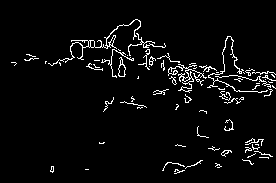


Pollution Score: 94.7/100 (higher = worse)
Air Quality: Poor (Heavy Pollution)
New image analysis complete! Score: 94.7/100


In [ ]:
# Analyze the new image
new_score = detect_pollution("/content/polluted.jpeg")
if new_score is not None:
    print(f"New image analysis complete! Score: {new_score:.1f}/100")
else:
    print("Analysis failed.")